In [1]:
import os
import cv2
import glob
from shutil import copyfile

# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

1.14.0


In [42]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, pretrain_model_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = tf.GraphDef.FromString(open(pretrain_model_path,'rb').read())

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
#         (375, 1242, 3)
        height = image.shape[0]
        width = image.shape[1]
        # NOTE: use original image to predict
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        
        return seg_map

In [7]:
base_path = "/userhome/34/h3567721/dataset/kitti/raw_data_test_sem/2011_09_26/2011_09_26_drive_0106_sync/image_02/data"

In [11]:
sem = np.load(os.path.join(base_path, "0000000015.npy"))

In [10]:
ins = np.load(os.path.join(base_path, "0000000015_instance_new.npy"))

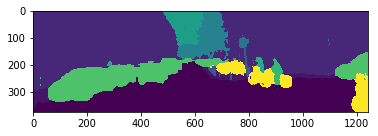

In [9]:
plt.imshow(sem)

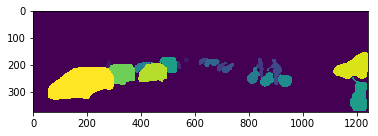

In [13]:
plt.imshow(ins[:,:,0])

In [2]:
%matplotlib inline 
plt.imshow(ins[:,:,1])

NameError: name 'plt' is not defined

In [37]:
rgb_img = cv2.imread(os.path.join(base_path, "0000000015.png")) 

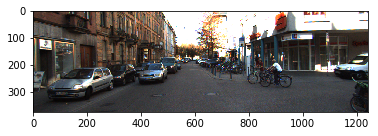

In [38]:
plt.imshow(rgb_img)

In [39]:
pretrain_model_path = "/userhome/34/h3567721/projects/Depth/deeplab/deeplabv3_cityscapes_train/frozen_inference_graph.pb"

In [44]:
MODEL = DeepLabModel(pretrain_model_path)

In [45]:
seg_map = MODEL.run(rgb_img)

In [46]:
seg_map.shape

(375, 1242)

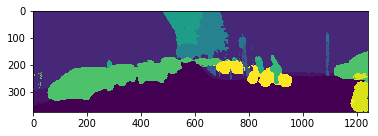

In [47]:
plt.imshow(seg_map)